In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

In [2]:
# parse contractSymbol date
def parse_contractSymbol(cs, rdate=False, asdict=False):
    #     cs = 'PLTR210108C00025000'
    ticker = cs [:-15]
    year = cs[-15:-13]
    month = cs[-13:-11]
    day = cs[-11:-9]
    instr_type = cs[-9]
    strike = float(cs[-8:])/1000
    
    if rdate == True:
        return date(2000+int(year), int(month), int(day))
    
    if asdict == True:
        return {
            'ticker': ticker,
            'year': year,
            'month': month,
            'day': day,
            'instr_type': instr_type,
            'strike': strike,
        }
    return (ticker, year, month, day, instr_type, strike)

# parse_contractSymbol('PLTR210108C00025000') # ('PLTR', '21', '01', '08', 'C', 25.0)
# parse_contractSymbol('PLTR210108C00025000', rdate=True) # 

# pick one the most interesting contract symbol
def max_interest_by(df, col='openInterest'):
    return df.loc[df.sort_values(by=[col], ascending=False)[col].idxmax()] # Series


# ('2021-01-15', 30.0, 80195)

In [3]:
def add_z_score(df, column='openInterest'):
    """
    Calculates z-score based on values of the given column. 
    Appends a column with stored results.
    """
    new_df = df.copy()
    new_df[column+'Z'] = (df[column] - df[column].mean())/df[column].std()
    return new_df


def filter_by_z_score(df, column='openInterest', mean=True, let=.5):
    """
    Filters df by its z-score. 
    mean - if True, takes all values higher than mean z-score
    let - larger or equal than value
    """
    if mean:
        return df.loc[df[column+'Z'] > df[column+'Z'].describe()['mean']]
    
    return df.loc[df[column+'Z'] >= let]


def datetime_valid(dt_str):
    try:
        datetime.fromisoformat(dt_str)
    except:
        return False
    return True

def filter_by_date(df, date, column='exp'):
    """
    Second argument must be a datetime.date object
    """
    #     if not datetime_valid(str(date)):
    #         raise Exception(f"Second positional argument must be valid iso format date - yyyy-mm-dd. Received {date}")
    #     if type(date) is not 'datetime.date':
    #         raise Exception(f"Second positional argument must be datetime.date object. Received {type(date)}")
    return df[df[column] == date]

    
# filter_by_date(calls, exps[4])

# filter_by_z_score(add_z_score(filter_by_date(calls, exps[0]), column='volume'), column='volume')

def calculate_horizon_date(time_horizon):
    """
    Maps time_horizon = ['next', '1mo', '3mo', '6mo', '1y', '2y', 'max'] to datetime.date object
    """
    today = date.today()
    if time_horizon == '1w':
        return today + timedelta(7)
    if time_horizon == '2w':
        return today + timedelta(7*2)
    if time_horizon == '3w':
        return today + timedelta(7*3)
    if time_horizon == '1mo':
        return today + timedelta(31*1)
    if time_horizon == '3mo':
        return today + timedelta(31*3)
    if time_horizon == '6mo':
        return today + timedelta(31*6)
    if time_horizon == '1y':
        return today + timedelta(365)
    if time_horizon == '2y':
        return today + timedelta(365*2)
    if time_horizon == 'max':
        return today + timedelta(365*100)
    raise Exception("time_horizon must be ['1w', '2w', '3w', '1mo', '3mo', '6mo', '1y', '2y', 'max']")
    
def interesting_options(op_chain, column='openInterest', time_horizon='max', filter_by_expiration=True, z_score_mean=True, z_score_let=False):
    """
    Takes a full option chain and filters based on z-score. 
    
    time_horizon = ['1w', '2w', '3w', '1mo', '3mo', '6mo', '1y', '2y', 'max']
    """
    
    df = op_chain.copy()
    
    # add expiration column
    df['exp'] = df['contractSymbol'].apply(lambda cs: parse_contractSymbol(cs, rdate=True))

    # filter by time_horizon
    horizon_date = calculate_horizon_date(time_horizon)
    df = df[df['exp'] <= horizon_date]
    
    # get unique expirations
    exps = df['exp'].unique() # (13,)
    
    # add stike column
    df['strike'] = df['contractSymbol'].apply(lambda cs: parse_contractSymbol(cs, asdict=True)['strike'])
    
    # set convinient dates and strikes for plot
    # df['date_strike'] = df['exp'].apply(lambda d: d.strftime('20%y-%m-%d'))

    def make_date_strike(cs):
        (ticker, year, month, day, instr_type, strike) = parse_contractSymbol(cs)
        return f"20{year}-{month}-{day} {strike}"
    
    df['date_strike'] = df['contractSymbol'].apply(lambda d: make_date_strike(d))
    
    # adding z-score
    new_df = pd.DataFrame([], columns=df.columns)
    for exp in exps:
        by_date = filter_by_date(df, exp) # filter by expiration date
        with_z = add_z_score(by_date, column=column)
        filtered_by_z = filter_by_z_score(with_z, 
                                          column=column, 
                                          mean=z_score_mean, 
                                          let=z_score_let)
        new_df = pd.concat([new_df, filtered_by_z], axis=0, ignore_index=True)
        
    return new_df
    
    
# pd.concat([new_df, jan_15, jan_22], axis=0, ignore_index=True)
# calls.shape # (436, 21)
# interesting_options(calls).shape # (103, 22)

In [35]:
mac = '~/Desktop/code/mamacita/algo2'
opin_calls = interesting_options(pd.read_csv(f'{mac}/csv/pltr/calls.csv', index_col=0),
                                time_horizon='2w')
print(opin_calls.shape)

(35, 23)


In [37]:
mac = '~/Desktop/code/mamacita/algo2'
calls = pd.read_csv(f'{mac}/csv/pltr/calls.csv', index_col=0)
opin_calls = interesting_options(calls, time_horizon='1y')
# print(calls.shape) # (436, 20)
# print(opin_calls.shape) # (103, 23)

calls1 = pd.read_csv(f'{mac}/csv/pltr/calls1.csv', index_col=0)
opin_calls1 = interesting_options(calls1, time_horizon='1y')
# print(calls1.shape) # (387, 20)
# print(opin_calls1.shape) # (108, 23)
opin_calls.head()
# opin_calls1.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,currency,undPriceAsk,undPriceBid,undPriceMid,undPriceLondonTime,undPriceTimestamp,mtime,exp,date_strike,openInterestZ
0,PLTR210115C00020000,2021-01-14 20:50:59,20.0,4.93,0.0,0.0,0.0,0.0,549.0,5142,...,USD,26.31,26.25,26.28,2021-01-15 11:51:03.797267,1.610711e+09,1.610712e+09,2021-01-15,2021-01-15 20.0,0.205940
1,PLTR210115C00023000,2021-01-14 20:58:42,23.0,1.85,0.0,0.0,0.0,0.0,524.0,9479,...,USD,26.31,26.25,26.28,2021-01-15 11:51:03.797267,1.610711e+09,1.610712e+09,2021-01-15,2021-01-15 23.0,0.633936
2,PLTR210115C00024000,2021-01-14 20:59:24,24.0,1.00,0.0,0.0,0.0,0.0,2550.0,6074,...,USD,26.31,26.25,26.28,2021-01-15 11:51:03.797267,1.610711e+09,1.610712e+09,2021-01-15,2021-01-15 24.0,0.297915
3,PLTR210115C00025500,2021-01-14 20:59:18,25.5,0.23,0.0,0.0,0.0,0.0,8200.0,6243,...,USD,26.31,26.25,26.28,2021-01-15 11:51:03.797267,1.610711e+09,1.610712e+09,2021-01-15,2021-01-15 25.5,0.314592
4,PLTR210115C00026500,2021-01-14 20:58:28,26.5,0.10,0.0,0.0,0.0,0.0,6746.0,9157,...,USD,26.31,26.25,26.28,2021-01-15 11:51:03.797267,1.610711e+09,1.610712e+09,2021-01-15,2021-01-15 26.5,0.602160


In [49]:
print(type(opin_calls['exp'][0])) # <class 'datetime.date'>
print(type(opin_calls['date_strike'][0])) # <class 'str'>

<class 'datetime.date'>
<class 'str'>


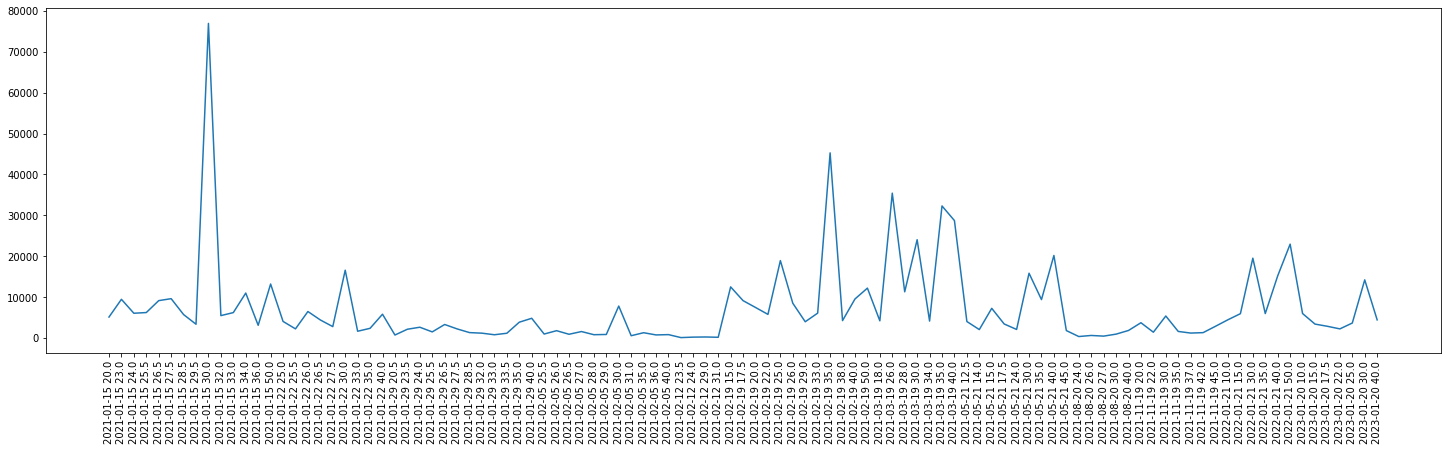

In [11]:
# plots openInterest
plt.figure(figsize=(25,10))
# fig.tight_layout()
plt.xticks(rotation=90)
# locs, labels = plt.xticks(np.arange(0, len(opin_calls['exp']),1), opin_calls['exp'])
# locs, labels = plt.xticks(np.arange(0, len(opin_calls['date_strike']),1), opin_calls['date_strike'])
plt.subplots_adjust(bottom=.4)
plt.plot(opin_calls['date_strike'], opin_calls['openInterest']) # 103


In [101]:
opin_calls.shape

(103, 23)

In [46]:
# problem if I want to plot calls and calls1 together on one graph - x lengths are diff - 108 & 103
# I need to combine columns

df = pd.DataFrame(opin_calls['openInterest'].values, index=opin_calls['date_strike'])
df1 = pd.DataFrame(opin_calls1['openInterest'].values, index=opin_calls1['date_strike'])
df.columns = ['df']
df1.columns = ['df1']
df2 = df.combine_first(df1)
# df2.shape
# df2.to_csv('./csv/pltr/df2.csv')

(131, 2)

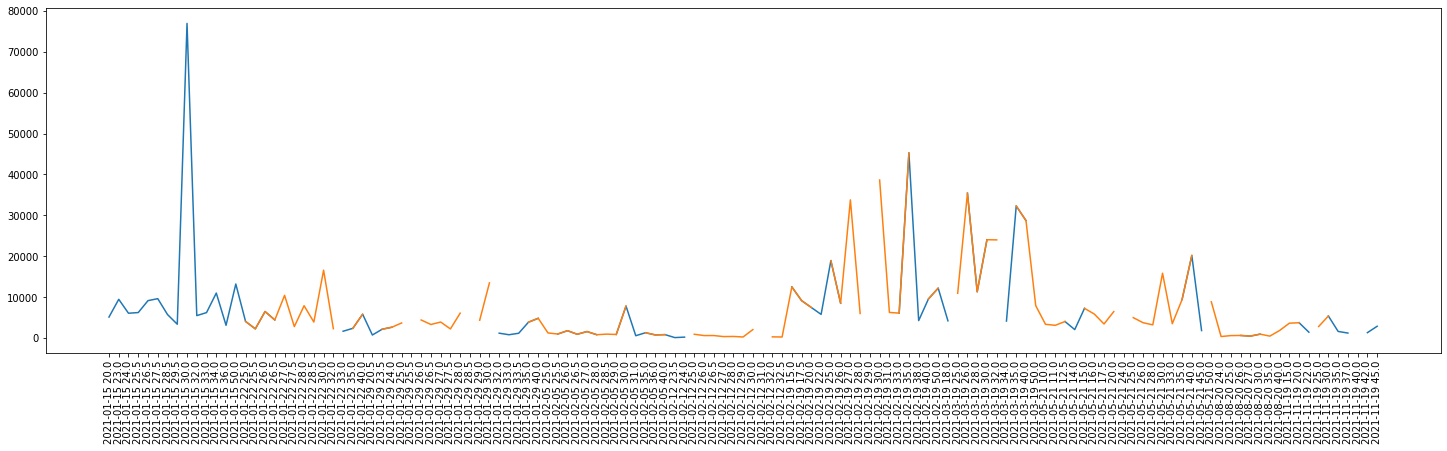

In [39]:
# plots openInterest
plt.figure(figsize=(25,10))
# fig.tight_layout()
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=.4)
plt.plot(df2['df']) # 103
plt.plot(df2['df1']) # 108

<BarContainer object of 131 artists>

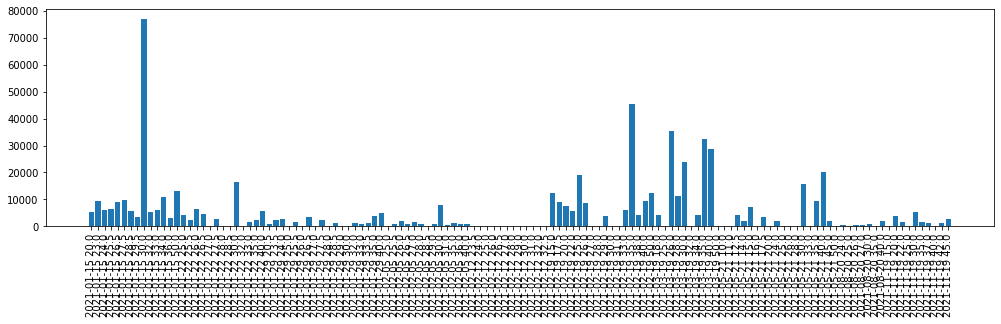

In [40]:
plt.figure(figsize=(17,4))
plt.xticks(rotation=90)
plt.bar(df2.index, df2['df'])

<BarContainer object of 149 artists>

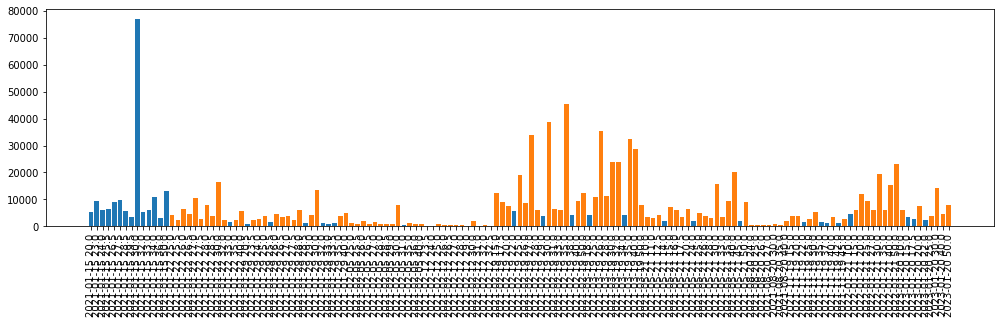

In [17]:
plt.figure(figsize=(17,4))
plt.xticks(rotation=90)
plt.bar(df2.index, df2['df'])
plt.bar(df2.index, df2['df1'])

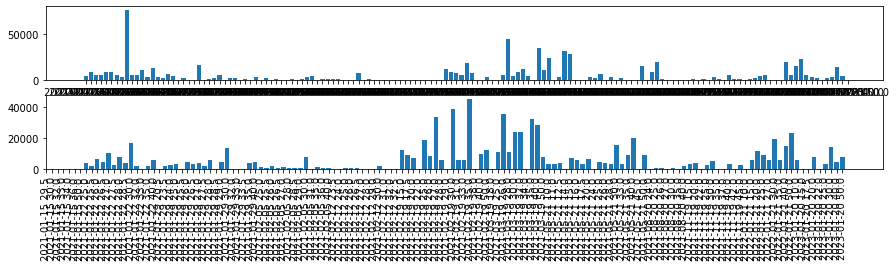

In [25]:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html

fig, (ax1, ax2) = plt.subplots(2, figsize=(15,3))
ax1.bar(df2.index, df2['df'])
ax2.bar(df2.index, df2['df1'])

plt.xticks(rotation=90)
plt.show()

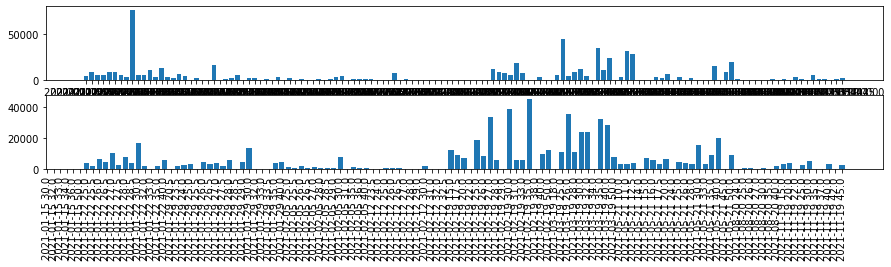

In [41]:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html

fig, (ax1, ax2) = plt.subplots(2, figsize=(15,3))
ax1.bar(df2.index, df2['df'])
ax2.bar(df2.index, df2['df1'])

plt.xticks(rotation=90)
plt.show()

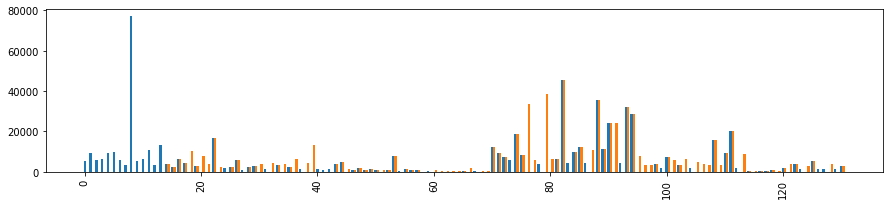

In [48]:
# https://www.pythoncharts.com/2019/03/26/grouped-bar-charts-matplotlib/
x = np.arange(0, len(df2.index),1)
bar_width = 0.4
fig, ax = plt.subplots(figsize=(15,3))
ax.bar(x, df2['df'], width=bar_width)
ax.bar(x + bar_width, df2['df1'], width=bar_width)

plt.xticks(rotation=90)
plt.show()

KeyError: 'date_strike'

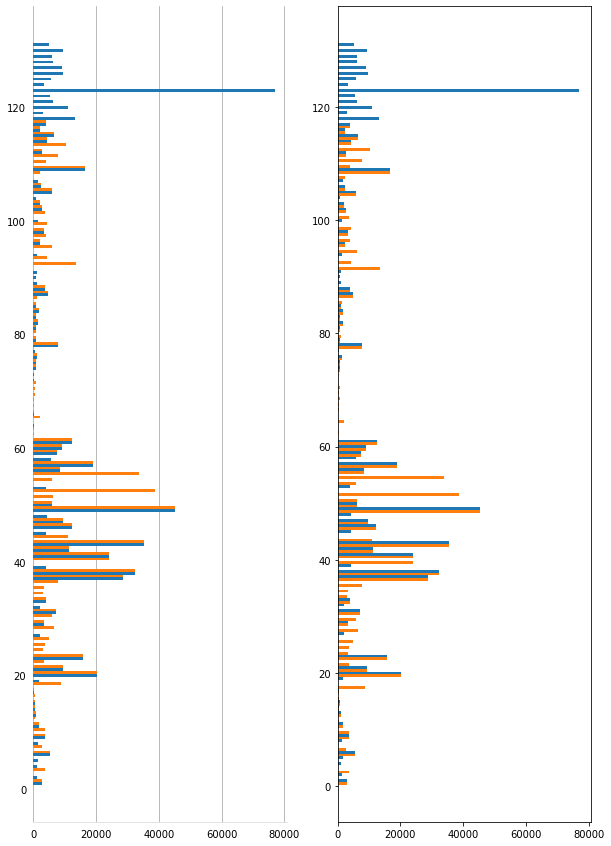

In [83]:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.barh.html
x = np.arange(len(df2.index), 0 , -1)
bar_width = 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,15))
ax1.barh(x, df2['df'], height=bar_width)
ax1.barh(x + bar_width, df2['df1'], height=bar_width)


ax2.barh(x, df2['df'], height=bar_width)
ax2.barh(x - bar_width, df2['df1'], height=bar_width)

# ax1.barh(df2['df'], width=bar_width)
# ax1.barh(df2['df1'], width=bar_width)
# ax2.barh(df2['df'], width=bar_width)
# ax2.barh(df2['df1'], width=bar_width)

# styling
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_color('#DDDDDD')
ax1.tick_params(bottom=False, left=False)
ax1.set_axisbelow(True)
ax1.yaxis.grid(False)
ax1.xaxis.grid(True, color='#AAAAAA')

# ax1.set_yticklabels(df2.index) # doesnt work

plt.xticks(rotation=90)


# locs, labels = plt.yticks()
# labels = df.index.values

plt.show()

In [13]:
puts = pd.read_csv('./csv/pltr/puts.csv', index_col=0)
opin_puts = interesting_options(puts)
# print(puts.shape) # (426, 20)
# print(opin_puts.shape) # (97, 23)

puts1 = pd.read_csv('./csv/pltr/puts1.csv', index_col=0)
opin_puts1 = interesting_options(puts1)
# print(puts1.shape) # (377, 20)
# print(opin_puts1.shape) # (97, 23)

opin_puts.plot(y='openInterest', 
        x='dates',
        kind='bar', 
        use_index=True, 
        logy=True, 
        figsize=(17,5),
       )

(426, 20)
(97, 23)
(377, 20)
(97, 23)


In [55]:
print(calls.shape)
print(puts.shape)

(103, 23)
(97, 23)


<Figure size 1224x360 with 0 Axes>